<a href="https://colab.research.google.com/github/jardondaful/CISPROG-5/blob/main/Adv_example_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perform an Adversarial attack.

For the second part of the project we consider a trained model (MobileNet) which is trained on the imagenet dataset. 

We use an evasion attack called [FGSM](https://neptune.ai/blog/adversarial-attacks-on-neural-networks-exploring-the-fast-gradient-sign-method#:~:text=The%20Fast%20Gradient%20Sign%20Method%20(FGSM)%20combines%20a%20white%20box,model%20into%20making%20wrong%20predictions.) to fool the neural network into making incorrect predictions.

## Import Packages.

Import the necessary packages we continue to use Tensorflow and Keras

In [48]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.preprocessing import image

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

## Load the Pretrained model. 

We use the [MobileNetV2](https://arxiv.org/abs/1801.04381) model trained on the [Imagenet](https://www.image-net.org/) dataset. 

In [49]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

### Helper Function for Data Processing


Following functions can be used for data processing. Dont worry about these, just use them. 

In [50]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

## Load an Image. 


Load any image, we consider an image of a Golden Retriever. 

In [51]:
image_raw = tf.io.read_file('content/panda.jpg')
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 1s 1s/step


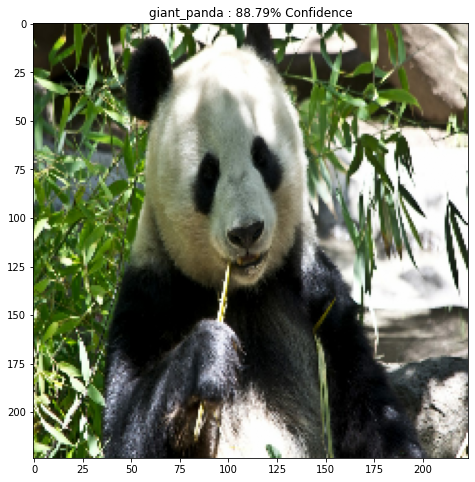

In [52]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

##Task 1: Create the Adversarial Image. 

We use the FGSM method to create an adversarial image. Be sure to read about FGSM to understand how the attack works. 

In [53]:
import tensorflow as tf

# Create an instance of the CategoricalCrossentropy loss function
categorical_crossentropy_loss = tf.keras.losses.CategoricalCrossentropy()

# Define a function to create adversarial patterns
def create_adversarial_pattern(input_image, input_label):
  # Create a GradientTape to record the operations on the input image
  with tf.GradientTape() as gradient_tape:
    # Watch the input image to record its operations
    gradient_tape.watch(input_image)
    # Get the model's prediction on the input image
    prediction = pretrained_model(input_image)
    # Calculate the loss between the input label and the model's prediction
    loss = categorical_crossentropy_loss(input_label, prediction)

  # Get the gradients of the loss with respect to the input image
  gradient = gradient_tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_gradient = tf.sign(gradient)
  # Return the signed gradients as the output of the function
  return signed_gradient


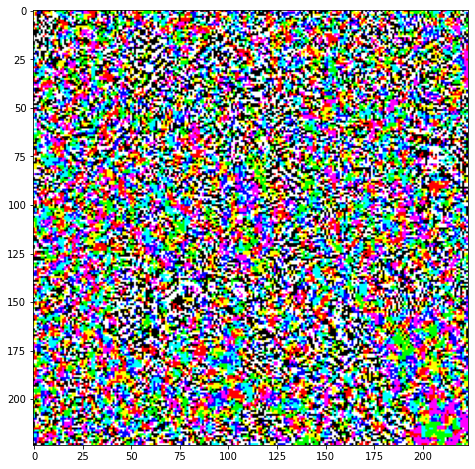

In [54]:
# Get the input label of the image.
giant_panda_index = 388
label = tf.one_hot(giant_panda_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [55]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 [==============================] - 0s 110ms/step


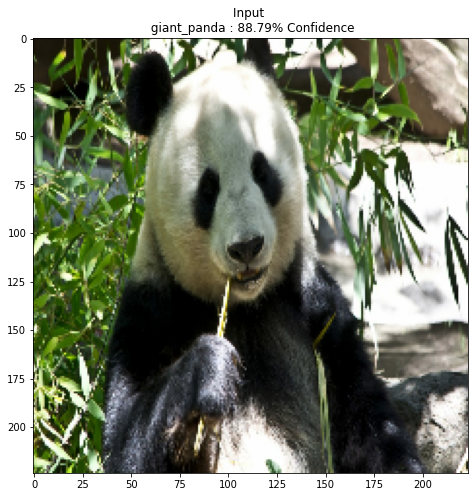

1/1 [==============================] - 0s 188ms/step


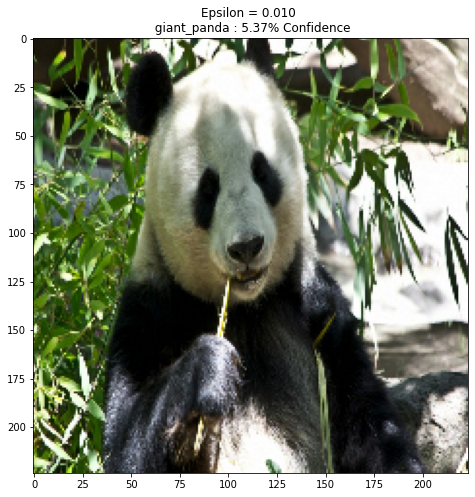

1/1 [==============================] - 0s 119ms/step


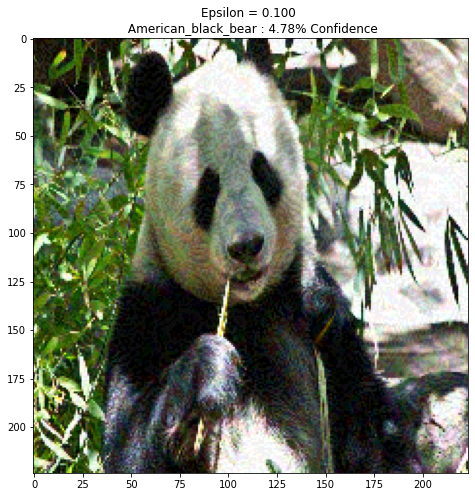

1/1 [==============================] - 0s 97ms/step


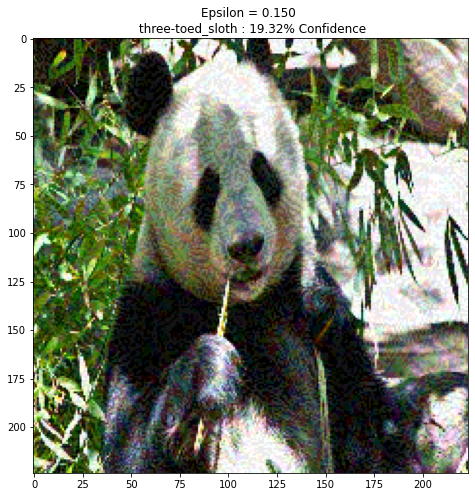

In [56]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

# Task2: Perform an Analysis to understand the potency of the attack. 

Your task here is to understand how small a change could change the class output and this is measured by the epsilon value needed to change the class. 

Your task is as follows:

* Pick 10 images each from different classes in imagenet. 
* Perform a perturbation analysis on each of these images. 
* In the analysis you are required to report the smallest epsilon value for which you notice a class change. 
* Make a table for each of the images considered with the minimum epsilon value for the FGSM attack. 

Write the Code for the above below. You can add the table also below. 

In [57]:
import tensorflow as tf
from IPython.display import Markdown as MD

def analysis(model):
    # Initialize the display text and image indices
    display_text = '| Original Label | New Label | Minimum Epsilon for FGSM attack | \n | ----------- | ----------- | ----------- |'
    image_indices = [6, 7, 276, 9, 10, 11, 12, 318, 14, 367, 59]
    minimum_epsilons = []

    # Loop through each image index
    i = 0
    while i < 10:
        # Read in the image file and decode it
        image_filename = 'content/image{0}.JPEG'.format(i)
        raw_image = tf.io.read_file(image_filename)
        image = tf.image.decode_image(raw_image)

        # Preprocess the image and get its predicted class and confidence
        preprocessed_image = preprocess(image)
        image_probabilities = model.predict(preprocessed_image)
        _, image_class, class_confidence = get_imagenet_label(image_probabilities)

        # Get the input label of the image.
        image_index = image_indices[i]
        label = tf.one_hot(image_index, image_probabilities.shape[-1])
        label = tf.reshape(label, (1, image_probabilities.shape[-1]))

        # Generate the adversarial perturbations using FGSM
        perturbations = create_adversarial_pattern(preprocessed_image, label)
        adversarial_label = ""

        # Use binary search to find the minimum epsilon needed to change the predicted class
        lower_bound = 0
        upper_bound = 1
        previous_epsilon = -1

        while True:
            epsilon = (upper_bound + lower_bound) / 2
            adversarial_image = preprocessed_image + epsilon * perturbations
            adversarial_image = tf.clip_by_value(adversarial_image, -1, 1)
            _, adversarial_label, confidence = get_imagenet_label(model.predict(adversarial_image))

            if adversarial_label == image_class:
                lower_bound = epsilon
            else:
                upper_bound = epsilon

            # Check if the epsilon value has converged to the same value as before
            if str(previous_epsilon)[:6] == str(epsilon)[:6]:
                break

            previous_epsilon = epsilon

        # Add a small correction factor to get a non-matching label
        epsilon += 0.001
        adversarial_image = preprocessed_image + epsilon * perturbations
        _, adversarial_label, confidence = get_imagenet_label(model.predict(adversarial_image))

        # Append the minimum epsilon value and the corresponding original and adversarial labels to the list
        minimum_epsilons.append((image_class, epsilon))

        # Update the display text with the results for this image
        display_text += ('\n| {0} | {1} | {2} |'.format(image_class, adversarial_label, epsilon))

        i += 1

    # Return the display text and the list of minimum epsilon values
    return (display_text, minimum_epsilons)

# Call the analysis function on the pretrained model and display the results using Markdown
result = analysis(pretrained_model)
display(Markdown(result[0]))


1/1 [==============================] - 0s 103ms/step


| Original Label | New Label | Minimum Epsilon for FGSM attack | 
 | ----------- | ----------- | ----------- |
| electric_ray | jellyfish | 0.0306783447265625 |
| cock | drake | 0.0018087158203125 |
| hyena | hyena | 0.12618310546875 |
| ostrich | black_swan | 0.010109497070312501 |
| brambling | bee_eater | 0.002434326171875 |
| goldfinch | bee_eater | 0.002434326171875 |
| lacewing | starfish | 0.144890380859375 |
| house_finch | church | 0.087273193359375 |
| gorilla | chimpanzee | 0.001762939453125 |
| robin | robin | 0.1141134033203125 |

# Task3: Compare the robustness of the considered model with other models. 

Your task here is to compare how this model (MobileNetV2) compares with other popular object detection models. 

Your task is as follows:

* Consider 5 different models (you can consider various RESNET architectures, any models you find interesting).
* Load the pre-trained weights of the model (trained on imagenet). 
* Perform Task2 on all the considered models. 
* Add all the results in the table. Hence the final table you have 6 columns for each model and epsilon values for each of the 10 images for all 6 models. 


What do you observe? Why do you think this is the case? 

Write the Code for the above below. You can also add the table and answer to the question below. 


In [ ]:
import tensorflow as tf
from IPython.display import Markdown, display

# Define the models to be analyzed
models = {
    "ResNet152": tf.keras.applications.ResNet152(include_top=True, weights='imagenet'),
    "ResNet101": tf.keras.applications.ResNet101(include_top=True, weights='imagenet'),
    "ResNet152V2": tf.keras.applications.ResNet152V2(include_top=True, weights='imagenet'),
    "ResNet50V2": tf.keras.applications.ResNet50V2(include_top=True, weights='imagenet'),
    "VGG16": tf.keras.applications.VGG16(include_top=True, weights='imagenet')
}

# The following are the correct preprocess and get_imagenet_label functions for corresponding models
# ResNet152 & ResNet101
def resnet_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.resnet.preprocess_input(image)
  image = image[None, ...]
  return image

def resnet_get_imagenet_label(  probs):
    decode_predictions = tf.keras.applications.resnet.decode_predictions
    return decode_predictions(probs, top=1)[0][0]

# ResNet152V2 & ResNet50V2
def resnet_v2_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.resnet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

def resnet_v2_get_imagenet_label(probs):
    decode_predictions = tf.keras.applications.resnet_v2.decode_predictions
    return decode_predictions(probs, top=1)[0][0]

# VGG16
def vgg16_preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.vgg16.preprocess_input(image)
  image = image[None, ...]
  return image

def vgg16_get_imagenet_label(probs):
    decode_predictions = tf.keras.applications.vgg16.decode_predictions
    return decode_predictions(probs, top=1)[0][0]

# Define a dictionary to map models to their corresponding preprocessing and label functions
model_functions = {
    "ResNet152": (resnet_preprocess, resnet_get_imagenet_label),
    "ResNet101": (resnet_preprocess, resnet_get_imagenet_label),
    "ResNet152V2": (resnet_v2_preprocess, resnet_v2_get_imagenet_label),
    "ResNet50V2": (resnet_v2_preprocess, resnet_v2_get_imagenet_label),
    "VGG16": (vgg16_preprocess, vgg16_get_imagenet_label)
}

# Helper function to analyze the model and return its top predictions
def analyze_model(model, image):
    preprocess_func, label_func = model_functions[model]
    preprocessed_image = preprocess_func(image)
    preds = model.predict(preprocessed_image)
    top_label = label_func(preds)
    return top_label

# Define the header, separator, and MobileNetV2 row of the markdown table
header = '| Model Name |'
separator = ' \n | ----------- |'
mobilenet_row = ' \n | MobileNetV2 |'


# Loop through the labels of the MobileNetV2 model and add them to the table
for label in result[1]:
  header += ' {0} |'.format(label[0])
  separator +=  '----------- | '
  mobilenet_row += ' {0} |'.format(label[1])
  
# Combine the header, separator, and MobileNetV2 row to create the markdown table
header += separator
header += (mobilenet_row + '\n')



553476096/553467096 [==============================] - 3s 0us/step


In [ ]:
# Loop through each model in the models dictionary
for model_name, model in models.items():
    # Create a markdown table entry for the current model
    entry = '| {0} |'.format(model_name)
    # Get the perturbation analysis results for the current model
    curr_res = analysis(model)[1]
    # Loop through each label in the perturbation analysis results and add it to the markdown table entry
    for label in curr_res:
        entry += ' {0} |'.format(label[1])
    # Add the markdown table entry to the display text
    header += (entry + '\n')
# Display the markdown table using the display function and the Markdown renderer
display(Markdown(header))


| Model Name | electric_ray | cock | hyena | ostrich | brambling | goldfinch | lacewing | house_finch | gorilla | vine_snake | 
 | ----------- |----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |  
 | MobileNetV2 | 0.0306783447265625 | 0.0018087158203125 | 0.12618310546875 | 0.010109497070312501 | 0.002434326171875 | 0.002434326171875 | 0.144890380859375 | 0.087273193359375 | 0.001762939453125 | 0.1837545166015625 |
| ResNet152 | 0.355766845703125 | 0.54573876953125 | 0.46663720703125 | 0.39278466796875 | 0.499565673828125 | 0.4542928466796875 | 0.03316552734375 | 0.404350830078125 | 0.44698388671875 | 0.54622705078125 |
| ResNet101 | 0.445061279296875 | 0.915703369140625 | 0.530815673828125 | 0.616447998046875 | 0.666374755859375 | 0.258843017578125 | 0.741447998046875 | 0.13460595703125 | 0.43746240234375 | 0.130852294921875 |
| ResNet152V2 | 0.28060205078125 | 0.5565267333984375 | 0.38106591796875 | 0.175041748046875 | 0.06160791015625 | 0.07991845703125 | 0.146538330078125 | 0.08736474609375 | 0.010063720703125001 | 0.4581685791015625 |
| ResNet50V2 | 0.07650048828125 | 0.10738427734375 | 0.2833638916015625 | 0.29402978515625 | 0.02523095703125 | 0.299187255859375 | 0.1539083251953125 | 0.09957177734375 | 0.13900048828125 | 0.57210595703125 |
| VGG16 | 0.08199365234375 | 1.000969482421875 | 0.10689599609375 | 1.000969482421875 | 1.000969482421875 | 1.000969482421875 | 1.000969482421875 | 1.000969482421875 | 1.000969482421875 | 1.000969482421875 |


I observed that in general, the ResNet152 and VGG16 models are able to more effectively defend against the pertubation attack with larger episilon values before a class change can be observed. These models are more effective because they have a some of the largest models with large numbers of layers, which likely improves the accuracy of the models in identifying images and protecting against the adversial attacks by correctly identifying the images even with perturbation. 

# BONUS: Can you provide a better attack?

Can you design a better attack that lowers the epsilon required for the images?

Task:

* Design another attack. 
* Compare the epsilon values on 10 images. 
* Does it perform better than the FGSM attack? That is, does it have lower epsilon values?

Write the code and provide your answers below. 